In [14]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.plot.width = 12, repr.plot.height = 12) 

In [15]:
# Read the zip file from url and unzip so it can be loaded into a dataframe
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00320/student.zip"
zip_file <- tempfile(fileext = ".zip")
download.file(url, zip_file, mode = "wb")
student_data <- read_delim(unz(description = zip_file, filename = "student-mat.csv"), delim = ";")

Parsed with column specification:
cols(
  .default = col_character(),
  age = col_double(),
  Medu = col_double(),
  Fedu = col_double(),
  traveltime = col_double(),
  studytime = col_double(),
  failures = col_double(),
  famrel = col_double(),
  freetime = col_double(),
  goout = col_double(),
  Dalc = col_double(),
  Walc = col_double(),
  health = col_double(),
  absences = col_double(),
  G1 = col_double(),
  G2 = col_double(),
  G3 = col_double()
)

See spec(...) for full column specifications.



In [16]:
# Grouped the Final Grade into intervals for easier labelling down the line
# Grades 0-5 is 1, 6-10 is 2, 11-15 is 3 and 16-20 is 4

student_data_group <- student_data %>%
    mutate(label = cut(G3, c(0, 9, 11, 13, 15, 20), 
                       #labels = c("fail", "sufficient", "satisfactory", "good", "excellent"), 
                       labels = c(1, 2, 3, 4, 5),
                       left = FALSE)) %>%
    group_by(label = as.factor(label)) %>%
    filter(!is.na(label))

head(student_data_group)

school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,⋯,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,label
<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
GP,F,18,U,GT3,A,4,4,at_home,teacher,⋯,3,4,1,1,3,6,5,6,6,1
GP,F,17,U,GT3,T,1,1,at_home,other,⋯,3,3,1,1,3,4,5,5,6,1
GP,F,15,U,LE3,T,1,1,at_home,other,⋯,3,2,2,3,3,10,7,8,10,2
GP,F,15,U,GT3,T,4,2,health,services,⋯,2,2,1,1,5,2,15,14,15,4
GP,F,16,U,GT3,T,3,3,other,other,⋯,3,2,1,2,5,4,6,10,10,2
GP,M,16,U,LE3,T,4,3,services,other,⋯,4,2,1,2,5,10,15,15,15,4


Will remove all the binary data columns

In [17]:
student_data_group_no_bin <- student_data_group %>%
    select(Medu, Fedu, traveltime, studytime, failures, famrel, freetime, goout, Dalc, Walc, health, absences, G1, G2, G3, label)

head(student_data_group_no_bin)

Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,label
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
4,4,2,2,0,4,3,4,1,1,3,6,5,6,6,1
1,1,1,2,0,5,3,3,1,1,3,4,5,5,6,1
1,1,1,2,3,4,3,2,2,3,3,10,7,8,10,2
4,2,1,3,0,3,2,2,1,1,5,2,15,14,15,4
3,3,1,2,0,4,3,2,1,2,5,4,6,10,10,2
4,3,1,2,0,5,4,2,1,2,5,10,15,15,15,4


In [18]:
# Split the data into training and testing set
#student_data_split <- initial_split(student_data_cleaned_binary, prop = 0.75, strata = label)
student_data_split <- initial_split(student_data_group_no_bin, prop = 0.75, strata = label)
student_train <- training(student_data_split)
student_test <- testing(student_data_split)


In [19]:
# Exploratory Data Analysis
# Distribution of mother's education level
student_train_meduc <- group_by(student_train, Medu) %>%
    summarize(n = n())

# Distribution of father's education level
student_train_feduc <- group_by(student_train, Fedu) %>%
    summarize(n = n())

# Counts number of student failures
student_train_failure <- group_by(student_train, failures) %>%
    summarize(n=n())

# Counts number of student absences
student_train_absences <- group_by(student_train, absences) %>%
    summarize(n=n())

# Computes mean of student absences
student_train_absences_m <- group_by(student_train) %>%
    summarize(absences_m = mean(absences))

# Computes mean family relationship quality
student_train_famrel <- group_by(student_train) %>%
    summarize(famrel = mean(famrel))

# Computes mean overall health status
student_train_health <- group_by(student_train) %>%
    summarize(health = mean(health))

# Computes mean student travel time
student_train_travel <- group_by(student_train) %>%
    summarize(traveltime = mean(traveltime))

# Student final grade distribution
student_train_G3 <- group_by(student_train, G3) %>%
    summarize(n = n())

head(student_train_meduc)
head(student_train_feduc)
head(student_train_failure)
head(student_train_absences)
head(student_train_absences_m)
head(student_train_famrel)
head(student_train_health)
head(student_train_travel)
student_train_G3

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



Medu,n
<dbl>,<int>
0,3
1,35
2,66
3,70
4,95


Fedu,n
<dbl>,<int>
1,52
2,75
3,78
4,64


failures,n
<dbl>,<int>
0,221
1,31
2,8
3,9


absences,n
<dbl>,<int>
0,54
1,2
2,51
3,7
4,43
5,5


absences_m
<dbl>
6.427509


famrel
<dbl>
3.884758


health
<dbl>
3.550186


traveltime
<dbl>
1.438662


G3,n
<dbl>,<int>
4,1
5,5
6,10
7,8
8,23
9,22
10,40
11,38
12,22


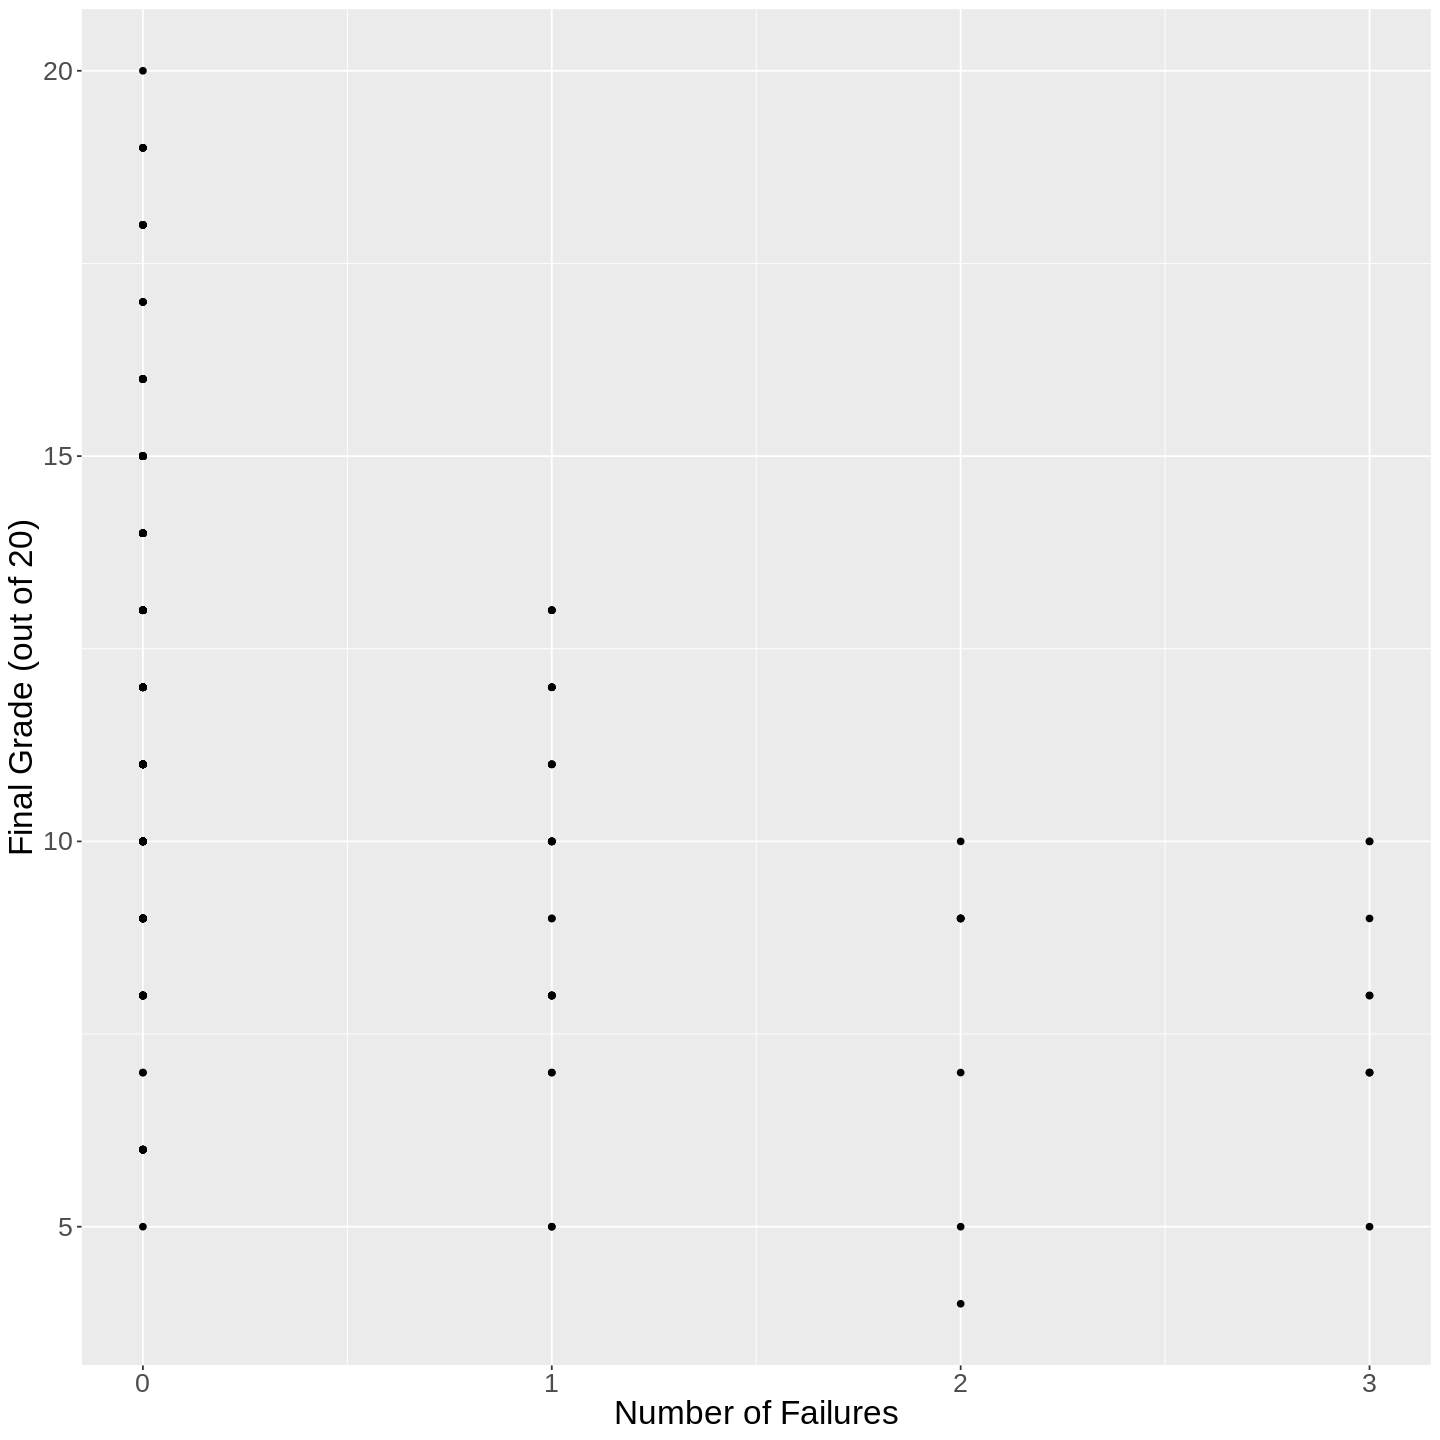

In [20]:
# Exploratory plot of Final Grade vs Number of Failures
student_plot <- ggplot(student_train, aes(x = failures, y = G3)) +
    geom_point() +
    labs(x = "Number of Failures" , y = "Final Grade (out of 20)") +
    theme(text = element_text(size = 20))
student_plot

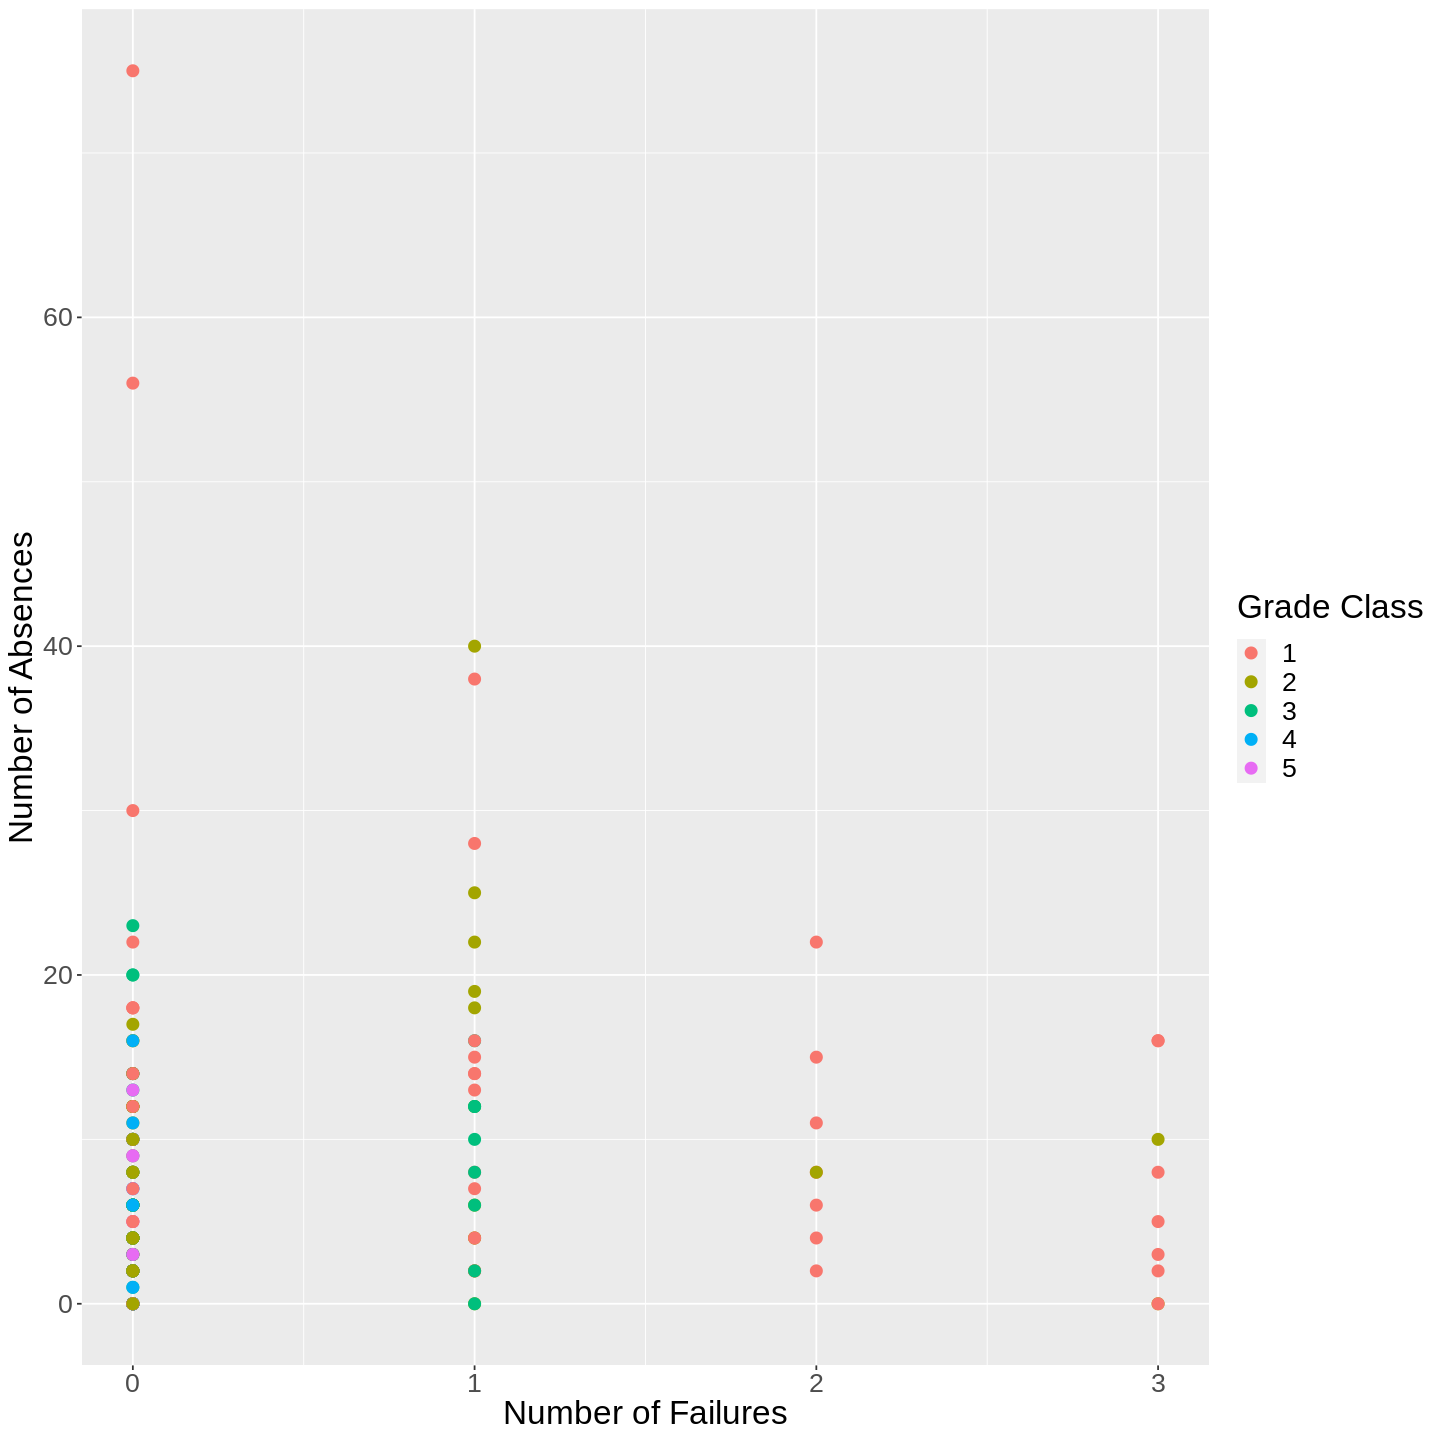

In [21]:
# Exporatory plot of Number of Absences vs Number of Failure with Grades as class labels
student_plot2 <- ggplot(student_train, aes(x = failures, y = absences, fill = label)) +
    geom_point(aes(color = label), size = 3) +
    labs(x = "Number of Failures" , y = "Number of Absences", fill = "Grade Class", color = "Grade Class") +
    theme(text = element_text(size = 20))
student_plot2

In [22]:
# model specification to produce a baseline accuracy

set.seed(2020)
# Medu + Fedu + studytime + failures + famrel + health + absences
student_recipe <- recipe(label ~ Medu + Fedu + studytime + failures  + health + absences, 
                         data = student_train) %>%
     step_scale(all_predictors()) %>%
     step_center(all_predictors())
    
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) %>%
     set_engine("kknn") %>%
     set_mode("classification")


knn_fit <- workflow() %>%
     add_recipe(student_recipe) %>%
     add_model(knn_spec) %>%
     fit(data = student_train)

knn_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_scale()
● step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = ~5, kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.6840149
Best kernel: rectangular
Best k: 5

In [23]:
#
student_test_pred <- predict(knn_fit, student_test) %>%
    bind_cols(student_test)

accuracy = student_test_pred %>%
    metrics(truth = label, estimate = .pred_class)

confusion = student_test_pred %>%
    conf_mat(truth = label, estimate = .pred_class)

accuracy
confusion

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.20454545
kap,multiclass,-0.02189781


          Truth
Prediction 1 2 3 4 5
         1 5 7 5 3 2
         2 9 6 5 2 3
         3 1 3 2 2 2
         4 6 8 3 5 3
         5 2 1 0 3 0

With 5 neighbours we found that the accuracy is only 26% and we can definitely do better. We will tune our classifier in order to increase our accuracy.

In [24]:
# cross-validation
student_vfold <- vfold_cv(student_train, v = 5, strata = label)

set.seed(2020)

student_recipe_2 <- recipe(label ~ Medu + Fedu + studytime + failures  + health + absences, 
                         data = student_train) %>%
     step_scale(all_predictors()) %>%
     step_center(all_predictors())

knn_fit_2 <- workflow() %>%
    add_recipe(student_recipe_2) %>%
    add_model(knn_spec) %>%
    fit_resamples(resamples = student_vfold)

knn_fit_2 %>% collect_metrics()

.metric,.estimator,mean,n,std_err
<chr>,<chr>,<dbl>,<int>,<dbl>
accuracy,multiclass,0.2817451,5,0.02283336
roc_auc,hand_till,0.5528744,5,0.02236454


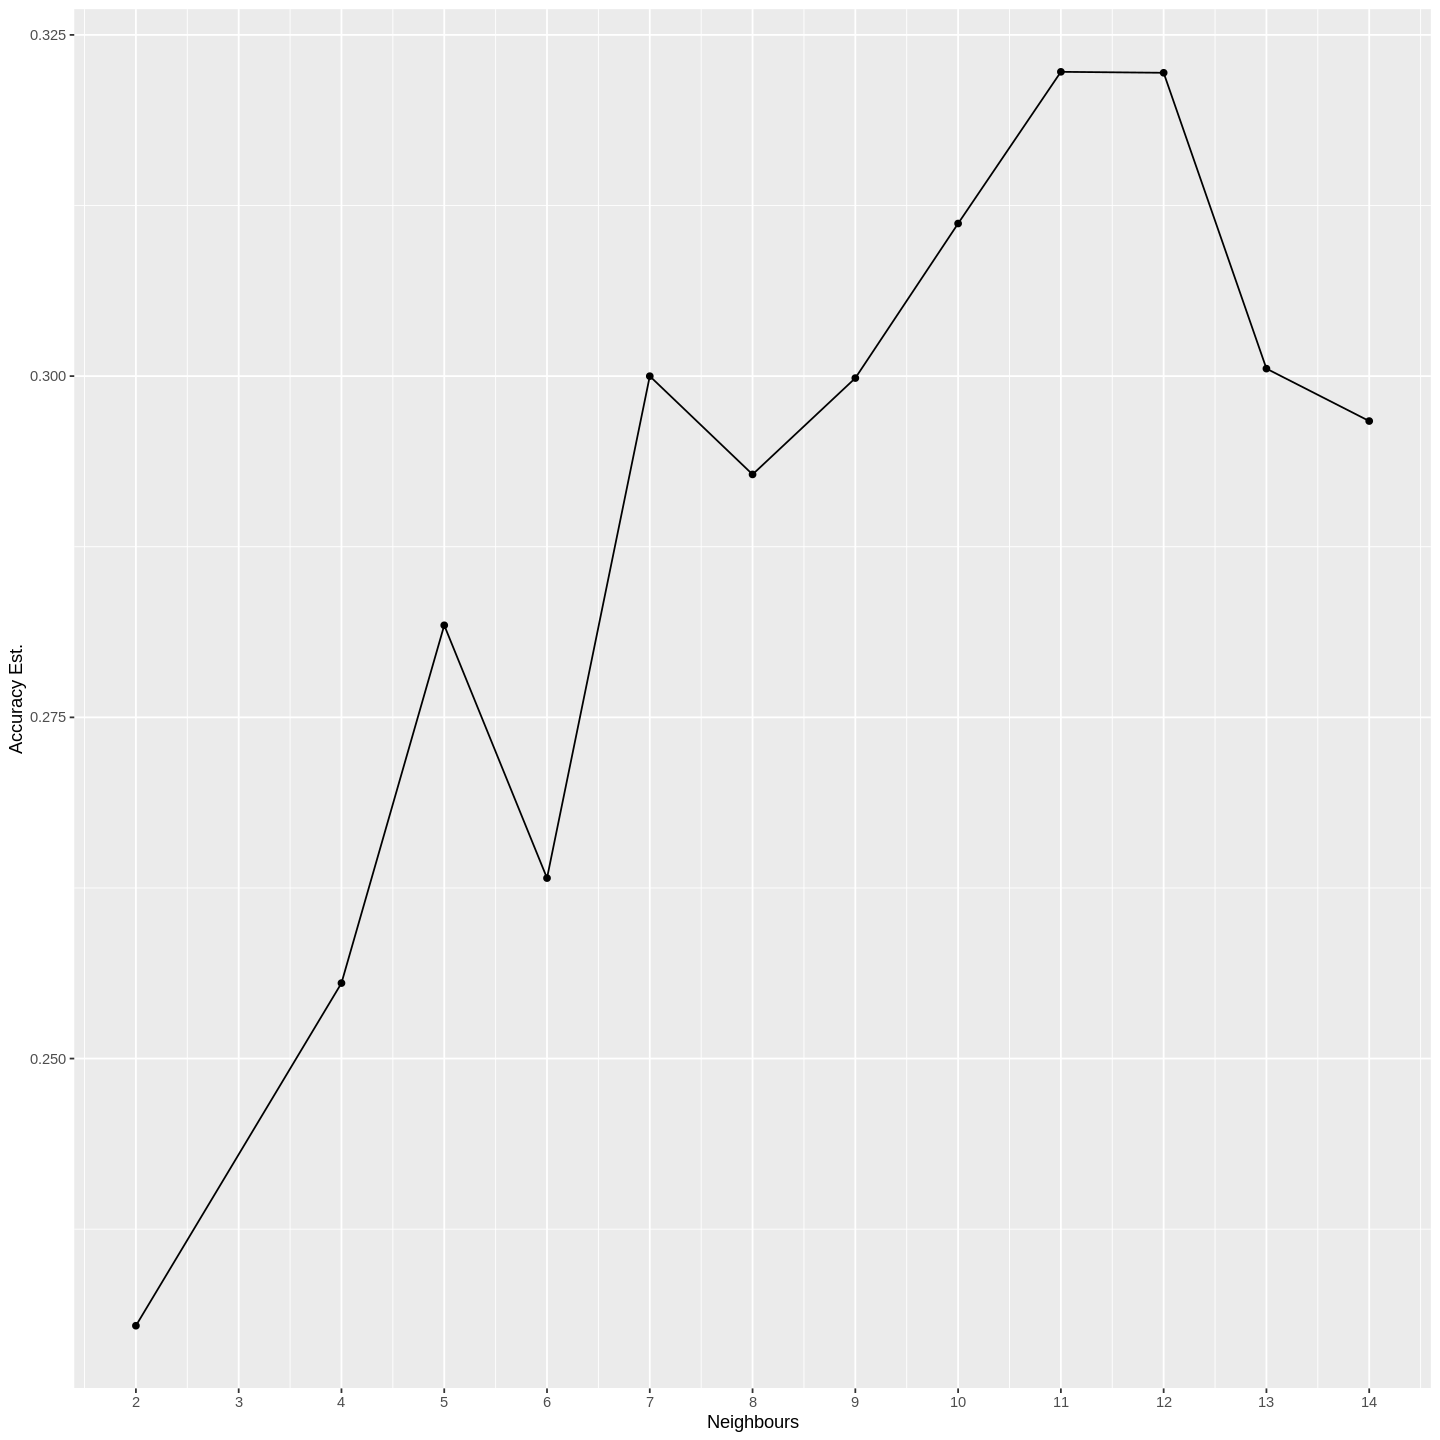

In [26]:
# Finding the best K by plotting accuracy vs K

knn_spec_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification")

set.seed(2020)

knn_results_tuned <- workflow() %>%
    add_recipe(student_recipe) %>%
    add_model(knn_spec_tune) %>%
    tune_grid(resamples = student_vfold, grid = 15) %>%
    collect_metrics()


accuracies <- knn_results_tuned %>%
    filter(.metric == "accuracy")

accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbours", y = "Accuracy Est.") +
    scale_x_continuous(breaks = 1:15)
    
accuracy_vs_k

The visualization suggests that $K$ =  14 provides the highest accuracy. Unfortunately, the accuracy is only slightly above our previous $K$ of 5. With $K$ = 14, the accuracy increases to just over 30%, while at $K$ = 5, the accuracy was 26%.

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_scale()
● step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = ~5, kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.732342
Best kernel: rectangular
Best k: 5

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.3409091
kap,multiclass,0.1601119


          Truth
Prediction  1  2  3  4  5
         1 10  5  1  2  1
         2  6  7  5  3  3
         3  2  5  5  4  3
         4  2  5  3  6  1
         5  3  3  1  0  2

.metric,.estimator,mean,n,std_err
<chr>,<chr>,<dbl>,<int>,<dbl>
accuracy,multiclass,0.2723718,5,0.02547679
roc_auc,hand_till,0.5247484,5,0.01545251


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.1976995,5,0.017901660,Model01
2,accuracy,multiclass,0.1976995,5,0.017901660,Model02
3,accuracy,multiclass,0.2087460,5,0.024084091,Model03
4,accuracy,multiclass,0.2539076,5,0.027250160,Model04
6,accuracy,multiclass,0.2795824,5,0.028029632,Model05
7,accuracy,multiclass,0.2611908,5,0.026451630,Model06
8,accuracy,multiclass,0.2351094,5,0.022610290,Model07
9,accuracy,multiclass,0.2456016,5,0.014559083,Model08
10,accuracy,multiclass,0.2457388,5,0.011301011,Model09


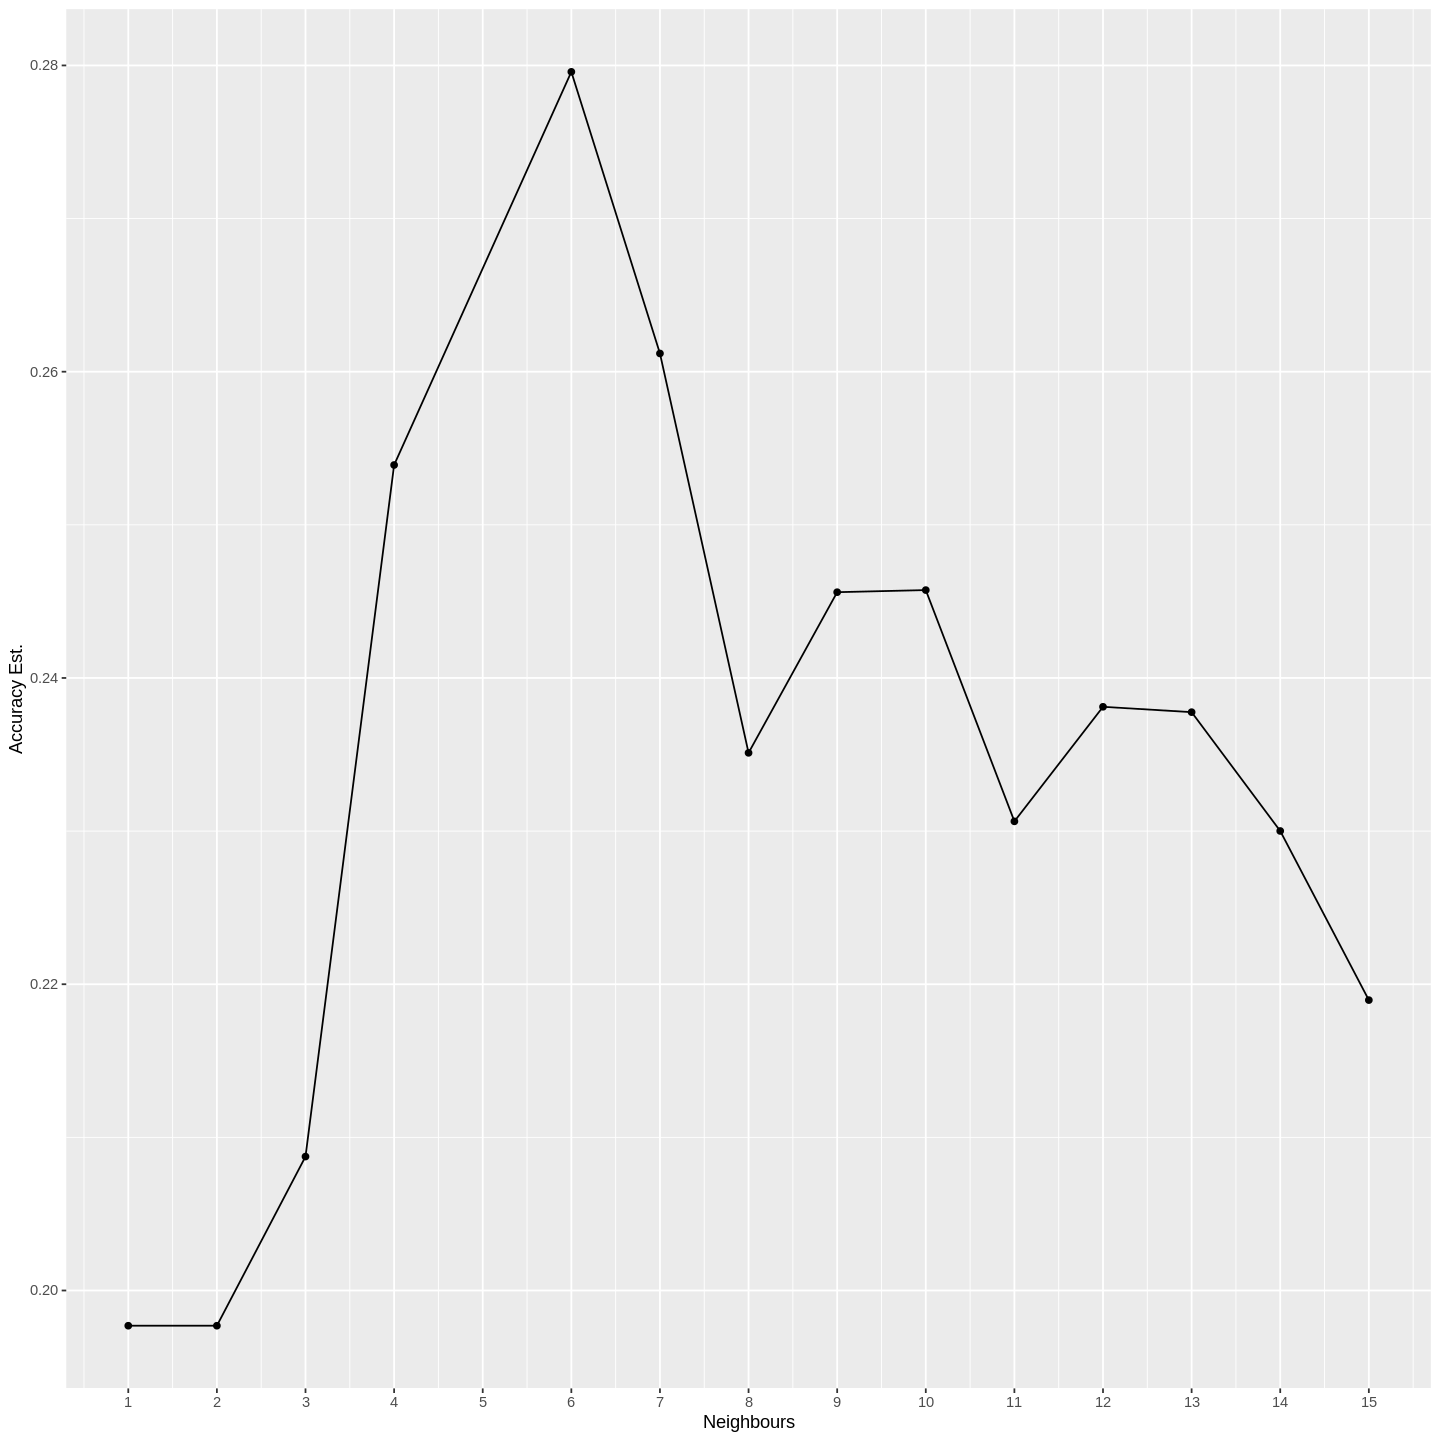

In [30]:
#### TEST

set.seed(2020)
# Medu + Fedu + studytime + failures + famrel + health + absences
student_recipe_time <- recipe(label ~ traveltime + goout + studytime + freetime + health + absences , 
                         data = student_train) %>%
     step_scale(all_predictors()) %>%
     step_center(all_predictors())
    
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) %>%
     set_engine("kknn") %>%
     set_mode("classification")


knn_fit_time <- workflow() %>%
     add_recipe(student_recipe_time) %>%
     add_model(knn_spec) %>%
     fit(data = student_train)

knn_fit_time

student_test_pred <- predict(knn_fit_time, student_test) %>%
    bind_cols(student_test)

accuracy = student_test_pred %>%
    metrics(truth = label, estimate = .pred_class)

confusion = student_test_pred %>%
    conf_mat(truth = label, estimate = .pred_class)

accuracy
confusion

student_vfold <- vfold_cv(student_train, v = 5, strata = label)


student_recipe_2_time <- recipe(label ~  traveltime  + goout + studytime + freetime + health + absences, 
                         data = student_train) %>%
     step_scale(all_predictors()) %>%
     step_center(all_predictors())

knn_fit_2_time <- workflow() %>%
    add_recipe(student_recipe_2_time) %>%
    add_model(knn_spec) %>%
    fit_resamples(resamples = student_vfold)

knn_fit_2_time %>% collect_metrics()

knn_spec_tune_time <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification")


knn_results_tuned_time <- workflow() %>%
    add_recipe(student_recipe_time) %>%
    add_model(knn_spec_tune_time) %>%
    tune_grid(resamples = student_vfold, grid = 15) %>%
    collect_metrics()

accuracies <- knn_results_tuned_time %>%
    filter(.metric == "accuracy")

accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbours", y = "Accuracy Est.") +
    scale_x_continuous(breaks = 1:15)
    
accuracy_vs_k